# Část druhá - regrese
Nejdříve načteme data a pro kategorický atribut OSType provedeme one-hot encoding. Zároven převedeme výsledné dummy sloupce na celočíselný typ (0 nebo 1). Také použijeme drop_first, abysme se zbavili jednoho dummy sloupce, který je redundantní. Zde odstraníme OSType_Android.

In [57]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [58]:
# Load the data
data = pd.read_csv('../data/data_2.csv')

# One-hot encoding for the 'OSType' column
data_encoded = pd.get_dummies(data, columns=['OSType'], drop_first=True)

# Convert the resulting dummy columns to integer data type
dummy_columns = data_encoded.filter(like='OSType_').columns
data_encoded[dummy_columns] = data_encoded[dummy_columns].astype(int)

# Displaying the first few rows of the data to verify the encoding
data_encoded.head()

,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms],OSType_MacOS,OSType_Windows,OSType_iOS
0,4113,0.8283,0.1717,47,0,0,1
1,7549,0.3461,0.6539,46,0,0,1
2,8855,0.2178,0.7822,55,0,1,0
3,8870,0.0794,0.9206,56,0,0,0
4,9559,0.7282,0.2718,76,1,0,0


### Tvorba modelu

### Kolinearita
Dále si vytvoříme korelační matici a následně si ji zobrazíme. Zde použijeme pouze prediktory - ActiveUsers, InteractingPct a ScrollingPct. 

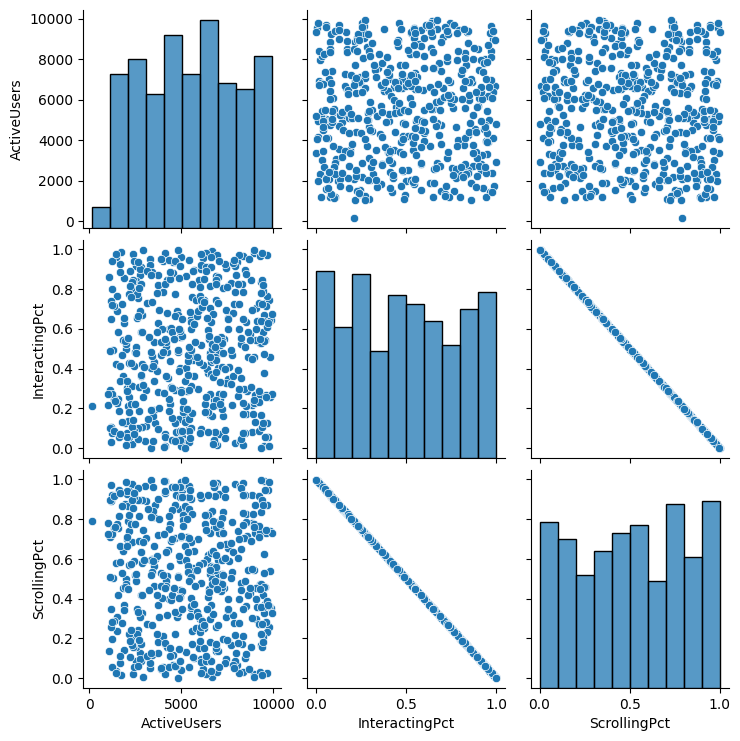

                ActiveUsers  InteractingPct  ScrollingPct
ActiveUsers        1.000000        0.040275     -0.040275
InteractingPct     0.040275        1.000000     -1.000000
ScrollingPct      -0.040275       -1.000000      1.000000


In [59]:
# Plotting pair-wise scatter plots
sns.pairplot(data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()

# Calculating and displaying correlation matrix
correlation_matrix = data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']].corr()
print(correlation_matrix)

V datech byla pozorována dokonalá negativní korelace (-1) mezi "InteractingPct" a "ScrollingPct" - jedná se o atributy, které jsou si doplňky. Tato situace naznačuje lineární závislost těchto dvou proměnných, což v regresní analýze může vést k problémům s multicolinearitou. Proto bylo rozhodnuto odstranit "ScrollingPct" z modelu, čímž se snižuje redundance a zvyšuje spolehlivost odhadů regresních koeficientů.

In [60]:
data_encoded.drop('ScrollingPct', axis=1, inplace=True)

### Vytvoření modelu


In [71]:
# Adding quadratic terms for numerical predictors
data_encoded['ActiveUsers_sq'] = data_encoded['ActiveUsers'] ** 2
data_encoded['InteractingPct_sq'] = data_encoded['InteractingPct'] ** 2

# Preparing the model
X = data_encoded.drop('Ping [ms]', axis=1)
X = sm.add_constant(X)
y = data_encoded['Ping [ms]']

# Fit the full quadratic model
model = sm.OLS(y, X).fit()
print(model.summary())

X

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     277.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.45e-166
Time:                        15:54:30   Log-Likelihood:                -1664.2
No. Observations:                 502   AIC:                             3344.
Df Residuals:                     494   BIC:                             3378.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.6819      1.68

,const,ActiveUsers,InteractingPct,OSType_MacOS,OSType_Windows,OSType_iOS,ActiveUsers_sq,InteractingPct_sq
0,1.0,4113,0.8283,0,0,1,16916769,0.686081
1,1.0,7549,0.3461,0,0,1,56987401,0.119785
2,1.0,8855,0.2178,0,1,0,78411025,0.047437
3,1.0,8870,0.0794,0,0,0,78676900,0.006304
4,1.0,9559,0.7282,1,0,0,91374481,0.530275
...,...,...,...,...,...,...,...,...
497,1.0,5315,0.1974,0,0,1,28249225,0.038967
498,1.0,1392,0.2373,1,0,0,1937664,0.056311
499,1.0,6014,0.8112,0,0,1,36168196,0.658045
500,1.0,5118,0.2345,0,0,0,26193924,0.054990


In [70]:
y

0      47
1      46
2      55
3      56
4      76
       ..
497    28
498    24
499    54
500    39
501    55
Name: Ping [ms], Length: 502, dtype: int64

### Normalizace prediktorů

Nyní normalizujeme prediktory, abychom dosáhli rovnocenného přínosu všech prediktorů. Využijeme MinMaxScaler, který převede hodnoty do intervalu `[0, 1]`.

In [62]:

# Normalizing the predictors
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)


In [63]:
# Backward Elimination
def backward_elimination(X, y, significance_level=0.05):
    variables = X.columns.tolist()
    while len(variables) > 0:
        X_with_const = sm.add_constant(X[variables])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues.iloc[1:]
        max_p = max(p_values)
        if max_p > significance_level:
            excluded_var = p_values.idxmax()
            variables.remove(excluded_var)
        else:
            break
    return variables

selected_vars = backward_elimination(X_normalized, y)
X_selected = X_normalized[selected_vars]


### VIF eliminace

In [64]:
# VIF Elimination
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Step 5: VIF Elimination - Analyzing and potentially removing a predictor with high VIF

def calculate_vif(X):
    """ Calculate Variance Inflation Factor for each variable in X """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for the selected predictors
vif_data = calculate_vif(X_selected)
vif_data


/home/terrorgarten/1SEM/MSP/MSP_P2/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Feature,VIF
0,const,NaN
1,ActiveUsers,42.719821
2,InteractingPct,3.446293
3,OSType_MacOS,2.008754
4,OSType_Windows,1.919698
5,OSType_iOS,1.780622
6,ActiveUsers_sq,27.643807


In [65]:

# Identifying and removing a predictor with high VIF if necessary
# Typically, a VIF value greater than 5 or 10 indicates high multicollinearity
high_vif_feature = vif_data[vif_data['VIF'] > 5]['Feature'].values
if len(high_vif_feature) > 0:
    # Removing the first predictor with high VIF
    X_selected_vif_reduced = X_selected.drop(high_vif_feature[0], axis=1)
else:
    X_selected_vif_reduced = X_selected

X_selected_vif_reduced.head()

,const,InteractingPct,OSType_MacOS,OSType_Windows,OSType_iOS,ActiveUsers_sq
0,0.0,0.829376,0.0,0.0,1.0,0.170573
1,0.0,0.346258,0.0,0.0,1.0,0.575168
2,0.0,0.217714,0.0,1.0,0.0,0.791484
3,0.0,0.079050,0.0,0.0,0.0,0.794168
4,0.0,0.729085,1.0,0.0,0.0,0.922377


### Denormalizace

In [66]:
# Denormalization - Reverting the normalized predictors to their original values
original_columns_to_denormalize = [col for col in X_selected_vif_reduced.columns if col != 'const']

# Extracting only the normalized columns from X_selected_vif_reduced
X_selected_normalized_subset = X_selected_vif_reduced[original_columns_to_denormalize]

# Fitting a new scaler to the columns retained in the final model and then denormalizing
scaler_subset = MinMaxScaler()
scaler_subset.fit(X[original_columns_to_denormalize])  # Fit the scaler to the original subset of columns
X_denormalized_subset = scaler_subset.inverse_transform(X_selected_normalized_subset)
X_denormalized_subset = pd.DataFrame(X_denormalized_subset, columns=original_columns_to_denormalize)

# Reconstructing the final dataset for the model
# Including the constant term and any other columns that were not normalized
X_final_denormalized = pd.concat([X_selected_vif_reduced[['const']], X_denormalized_subset], axis=1)

X_final_denormalized_corrected = sm.add_constant(X_denormalized_subset)

X_final_denormalized_corrected.head()

,const,InteractingPct,OSType_MacOS,OSType_Windows,OSType_iOS,ActiveUsers_sq
0,1.0,0.8283,0.0,0.0,1.0,16916769.0
1,1.0,0.3461,0.0,0.0,1.0,56987401.0
2,1.0,0.2178,0.0,1.0,0.0,78411025.0
3,1.0,0.0794,0.0,0.0,0.0,78676900.0
4,1.0,0.7282,1.0,0.0,0.0,91374481.0


### Detekce a odstranění odlehlých pozorování

In [67]:
# Assuming 'model' is the last fitted OLS model from which you want to identify outliers
# Calculate the residuals
residuals = model.resid

# Calculate the standard deviation of the residuals
residuals_std = residuals.std()

# Identify outliers as residuals that are more than 3 standard deviations from the mean
outliers = np.abs(residuals) > 3 * residuals_std

# Display the potential outlier index
outlier_indices = outliers[outliers].index
outlier_indices

Index([255, 476], dtype='int64')

### Odstranění odlehlých pozorování

In [72]:
# Remove the outliers from the predictors and the response variable
X_cleaned = X_final_denormalized_corrected.drop(outlier_indices)
y_cleaned = y.drop(outlier_indices)

# You should fit your regression model again with this cleaned data to get the updated model
final_model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()
print(final_model_cleaned.summary())
X_cleaned

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     241.3
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          4.34e-130
Time:                        15:55:54   Log-Likelihood:                -1744.3
No. Observations:                 500   AIC:                             3501.
Df Residuals:                     494   BIC:                             3526.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             28.2205      1.065     26.

,const,InteractingPct,OSType_MacOS,OSType_Windows,OSType_iOS,ActiveUsers_sq
0,1.0,0.8283,0.0,0.0,1.0,16916769.0
1,1.0,0.3461,0.0,0.0,1.0,56987401.0
2,1.0,0.2178,0.0,1.0,0.0,78411025.0
3,1.0,0.0794,0.0,0.0,0.0,78676900.0
4,1.0,0.7282,1.0,0.0,0.0,91374481.0
...,...,...,...,...,...,...
497,1.0,0.1974,0.0,0.0,1.0,28249225.0
498,1.0,0.2373,1.0,0.0,0.0,1937664.0
499,1.0,0.8112,0.0,0.0,1.0,36168196.0
500,1.0,0.2345,0.0,0.0,0.0,26193924.0


### Q-Q a resiudální grafy


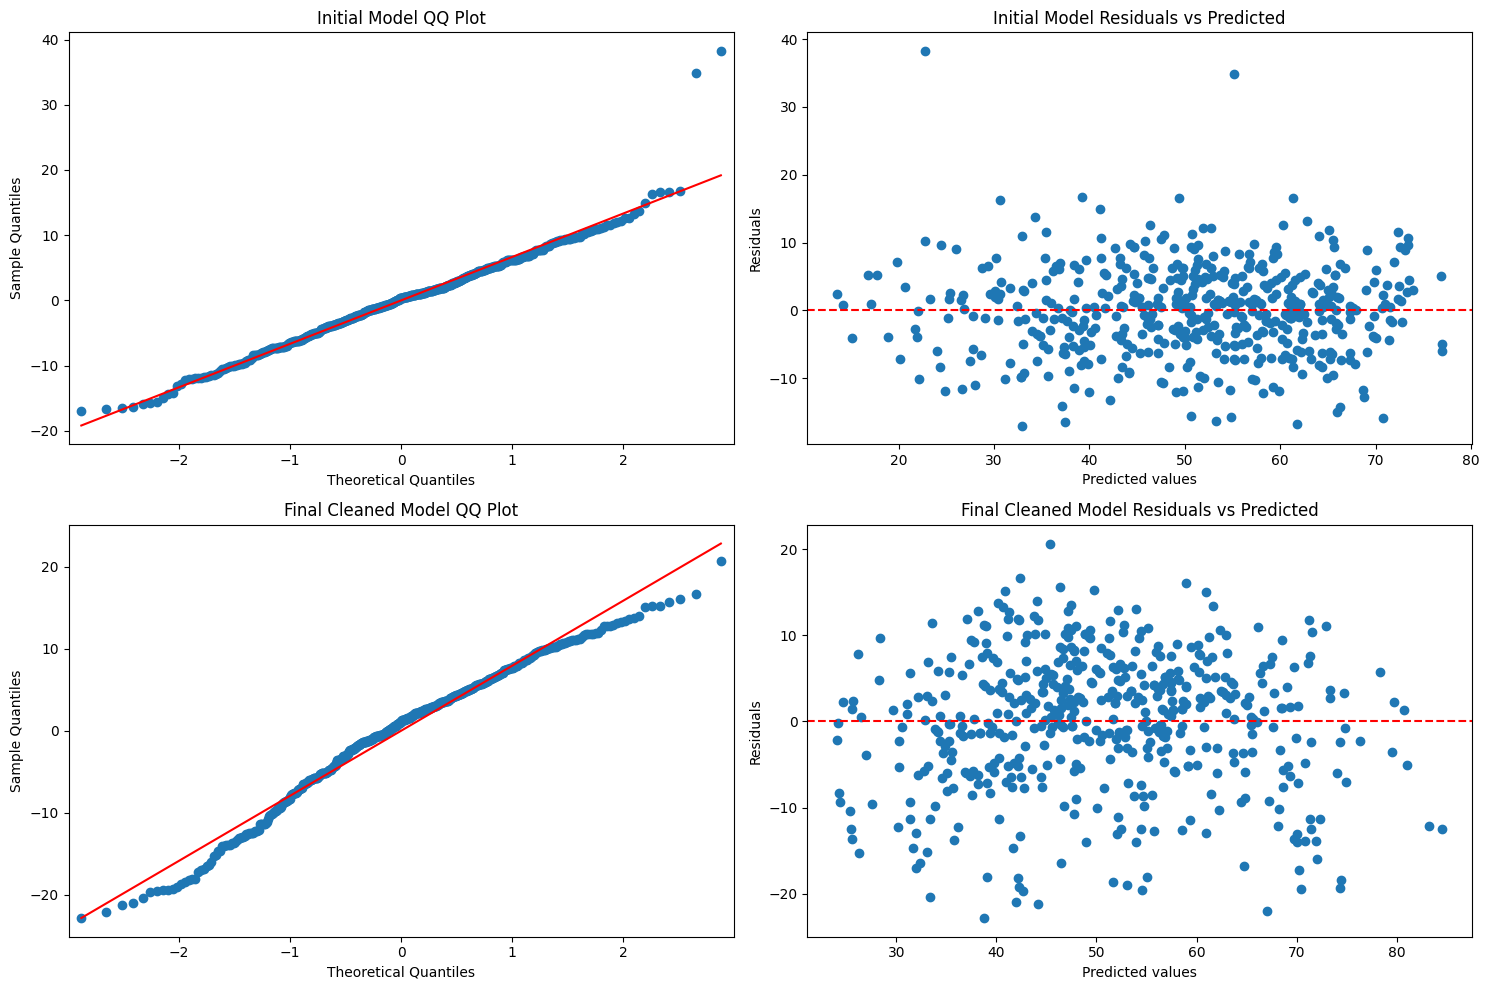

In [69]:
# Set up the matplotlib figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# QQ Plot for the initial model
sm.qqplot(model.resid, line='s', ax=axs[0, 0])
axs[0, 0].set_title('Initial Model QQ Plot')

# Residual vs. Predicted Values plot for the initial model
axs[0, 1].scatter(model.predict(X), model.resid)
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_xlabel('Predicted values')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].set_title('Initial Model Residuals vs Predicted')

# QQ Plot for the final cleaned model
sm.qqplot(final_model_cleaned.resid, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Final Cleaned Model QQ Plot')

# Residual vs. Predicted Values plot for the final cleaned model
axs[1, 1].scatter(final_model_cleaned.predict(X_cleaned), final_model_cleaned.resid)
axs[1, 1].axhline(y=0, color='red', linestyle='--')
axs[1, 1].set_xlabel('Predicted values')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].set_title('Final Cleaned Model Residuals vs Predicted')

plt.tight_layout()
plt.show()
